## Download Data

In [1]:
#!curl http://www.eecs.qmul.ac.uk/~urm30/HairMaterial/Figaro-1k.zip -o Figaro-1k.zip
#!unzip Figaro-1k.zip

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import fastai.basics as fai
import fastai.vision as fv
import numpy as np
from pathlib import Path
import torch
import torch.nn.functional as F
import torch.nn as nn
import gc
from torchvision import transforms

In [4]:
path_img = Path("Figaro-1k/Original")
path_label = Path("Figaro-1k/GT")

## Load Data

In [5]:
classNames = ["NoHair" for _ in range(255)] + ["Hair"] # Names of the classes

def get_label(img_name):
    #Get the label name of any image
    Name = Path(str(img_name.stem).replace("-org","-gt"))
    return (path_label / img_name.parent.stem / Name).with_suffix(".pbm")

def load_data(img_size, batch_size):
    tfms = fv.get_transforms() #The default fastai vision tansforms
    data = (fv.SegmentationItemList #We tell fastai we are doing a segemtna
            .from_folder(path_img) #The folder containing the data
            .split_by_folder(train="Training",valid="Testing")
            .label_from_func(get_label, classes=classNames) #Label from the defined function
            .transform(tfms, size=img_size, tfm_y=True) #Tell fastai to use data augmentation
            .databunch(bs=batch_size)
            .normalize(fv.imagenet_stats)) #Normalize using the imagenet mean and std
    return data

Data = load_data(500,4)

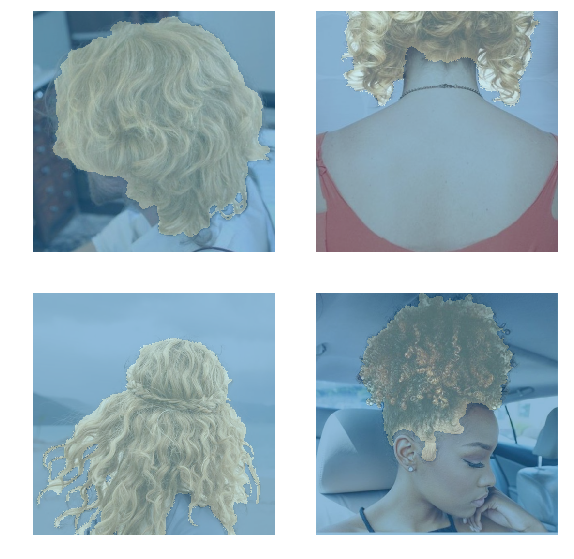

In [6]:
Data.show_batch()

In [5]:
def pixel_accuracy(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1) == target).float().mean()

In [6]:
Learn = fv.unet_learner(Data, fv.models.resnet34, pretrained=True, bottle=True, wd=0.1)
Learn.metrics.append(pixel_accuracy)

## Training

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-04


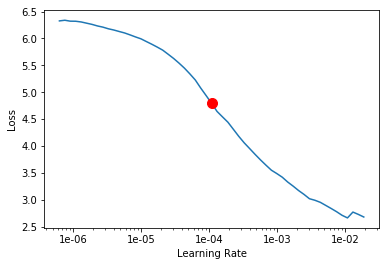

In [10]:
Learn.lr_find()
Learn.recorder.plot()

In [12]:
Learn.fit_one_cycle(5, max_lr=1e-3)

epoch,train_loss,valid_loss,pixel_accuracy
1,0.231629,0.199626,0.935345
2,0.158401,0.092127,0.963592
3,0.132385,0.085333,0.967090
4,0.106014,0.077868,0.970129
5,0.092896,0.071409,0.972303


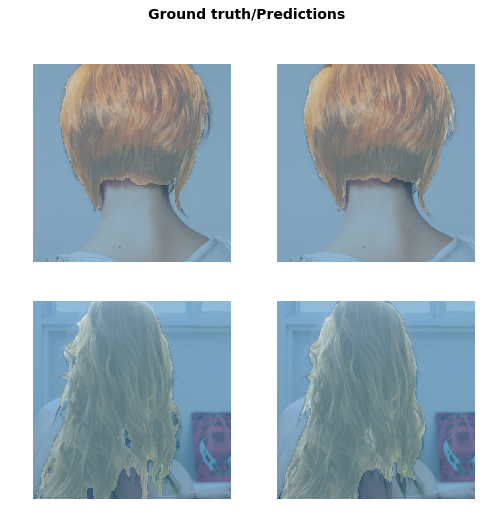

In [15]:
Learn.show_results(rows=2)

## Saving Model

In [59]:
# Below file Can be loaded to later resume training
Learn.save("HairCheckpoint.pth")
# Drop pixel accuracy metric
Learn.metrics = []
# Can be loaded to deploy and make predictions
Learn.export(Path("HairLearner.pkl").absolute())

## Make Predictions

In [6]:
Learn = fai.load_learner("./", "HairLearner.pkl")

In [49]:
Img = fv.open_image("Before.jpg")
originalSize = Img.size
Img = Img.resize(500)
Res = Learn.predict(Img)[0]

In [50]:
# Colorization
Mask = (Res.data == 255)
Color = [55, 100, 255]
R, G, B, A = [torch.zeros((1,500,500),dtype=torch.uint8) for _ in range(4)]
R[Mask], G[Mask], B[Mask] = Color
A[Mask] = 255
ColorMask = fv.Image(torch.cat([R,G,B,A]))

In [51]:
to_pil = transforms.ToPILImage()
Pil_Img = to_pil(ColorMask.data.detach().cpu().type(torch.ByteTensor))
Pil_Img = Pil_Img.resize(originalSize[::-1])
Pil_Img.save("ColorMask.png")

## Blending the images

In [52]:
import cv2 # OpenCV
from blend_modes import soft_light

In [53]:
background_img_float = cv2.imread("Before.jpg", -1)
background_img_float = cv2.cvtColor(background_img_float, cv2.COLOR_RGB2RGBA).astype(float) 
# Import mask image
mask_color_float = cv2.imread("ColorMask.png", -1).astype(float)

In [54]:
kernel = np.ones((5, 5), np.float32)/25
mask_color_float = cv2.filter2D(mask_color_float, -1, kernel)

In [55]:
# Blend the image
blended_img_float = soft_light(background_img_float, mask_color_float, opacity=0.7)
# Save it as bytes
blended_img_uint8 = blended_img_float.astype(np.uint8)
cv2.imwrite("Generated.png", blended_img_uint8)

True